In [1]:
import pandas as pd
import numpy as np
from tree.models import UpliftRandomForestClassifier
from tree.models import PMUpliftRandomForestClassifier
from causalml.dataset import make_uplift_classification
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'scipy'

In [2]:
df, x_names = make_uplift_classification()
df.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,...,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1105)

In [6]:
X = df_train[x_names].values
treatment = df_train['treatment_group_key'].values
y = df_train['conversion'].values

In [7]:
train_ids = np.arange(0, len(X))

In [8]:
train_ids

array([   0,    1,    2, ..., 3197, 3198, 3199])

In [9]:
num_treatments = len(set(treatment))
num_treatments

4

In [10]:
t_id = [0] * len(treatment)
for i in range(len(treatment)):
            if treatment[i] == "treatment1":
                t_id[i] = 1
            elif treatment[i] == "treatment2":
                t_id[i] = 2
            elif treatment[i] == "treatment3":
                t_id[i] = 3

In [11]:
from tree.batch_enhancement import BatchEnhancementOnX

In [12]:
batch = BatchEnhancementOnX()

In [13]:
t_id = np.array(t_id)

In [14]:
batch.make_propensity_lists(train_ids, X, t_id, num_treatments)

In [15]:
bt_index = np.random.choice(len(X), len(X))

In [16]:
bt_index

array([1552, 3178, 2091, ...,  171, 2205, 1271])

In [17]:
x_train_bt = X[bt_index]
y_train_bt = y[bt_index]
t_train_bt = t_id[bt_index]

In [18]:
t_indices = list(map(lambda t_idx: np.where(t_train_bt == t_idx)[0], range(num_treatments)))
t_lens = list(map(lambda x: len(x), t_indices))

In [19]:
base_treatment_idx = np.argmin(t_lens)
base_indices = t_indices[base_treatment_idx]

In [20]:
inner_x, inner_t, inner_y = x_train_bt[base_indices], t_train_bt[base_indices], y_train_bt[base_indices]

In [21]:
x_batch, t_batch, y_batch = batch.enhance_batch_with_propensity_matches(X, t_id, y, inner_x, inner_t, inner_y, num_treatments, 6)

In [22]:
x_batch

array([[ 0.20568698,  1.88960633,  0.89922654, ..., -1.24690472,
        -1.69359161, -1.58829633],
       [ 1.03658826, -0.07268558,  2.62317172, ..., -0.85975056,
        -0.95059997, -1.89922584],
       [-2.36665813, -0.85778401, -0.21540336, ..., -0.7636418 ,
        -1.81333523, -0.66519357],
       ...,
       [ 0.4746932 , -1.20297619,  0.03906243, ..., -1.33466661,
        -1.15898856, -1.32940279],
       [-0.46195296, -2.61173342,  0.02604388, ..., -0.79522928,
        -1.19051984, -0.79320465],
       [ 0.20435898, -4.75122988, -2.05600829, ..., -1.11260859,
         0.34836463, -0.26984757]])

In [23]:
t_batch

array([3, 3, 3, ..., 2, 2, 2])

In [24]:
t_batch_new = [0] * len(t_batch)       
for i in range(len(t_batch)):
    if t_batch[i] == 0:
        t_batch_new[i] = "control"
    elif t_batch[i] == 1:
        t_batch_new[i] = "treatment1"
    elif t_batch[i] == 2:
        t_batch_new[i] = "treatment2"
    else:
        t_batch_new[i] = "treatment3"
t_batch_new = np.array(t_batch_new)

In [25]:
t_batch_new

array(['treatment3', 'treatment3', 'treatment3', ..., 'treatment2',
       'treatment2', 'treatment2'], dtype='<U10')

In [26]:
treatment

array(['control', 'treatment2', 'treatment2', ..., 'treatment2',
       'control', 'treatment2'], dtype=object)

In [27]:
sum(t_batch_new == 'treatment1')

782

In [28]:
from tree.models import UpliftTreeClassifier

In [29]:
uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

In [30]:
uplift_model.fit(x_batch, t_batch_new, y_batch)

In [31]:
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

In [32]:
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

x15_uplift_increase >= -1.4979265398607582?
yes -> x18_uplift_increase >= -0.44830202033295674?
		yes -> x2_informative >= -0.24684911873725185?
				yes -> {'treatment3': 0.773585, 'treatment2': 0.274194, 'treatment1': 0.313253, 'control': 0.269231}
				no  -> {'treatment3': 0.910112, 'treatment2': 0.970588, 'treatment1': 0.763889, 'control': 0.74}
		no  -> x10_irrelevant >= -0.8007444122370163?
				yes -> {'treatment3': 0.478102, 'treatment2': 0.614458, 'treatment1': 0.486755, 'control': 0.665615}
				no  -> {'treatment3': 0.586667, 'treatment2': 0.470588, 'treatment1': 0.44, 'control': 0.363636}
no  -> x10_irrelevant >= -0.5310760990313537?
		yes -> x1_informative >= 0.050822301396146234?
				yes -> {'treatment3': 0.692308, 'treatment2': 0.551724, 'treatment1': 0.63964, 'control': 0.169811}
				no  -> {'treatment3': 0.641975, 'treatment2': 0.434783, 'treatment1': 0.692308, 'control': 0.402597}
		no  -> {'treatment3': 0.531646, 'treatment2': 0.479452, 'treatment1': 0.57377, 'control':

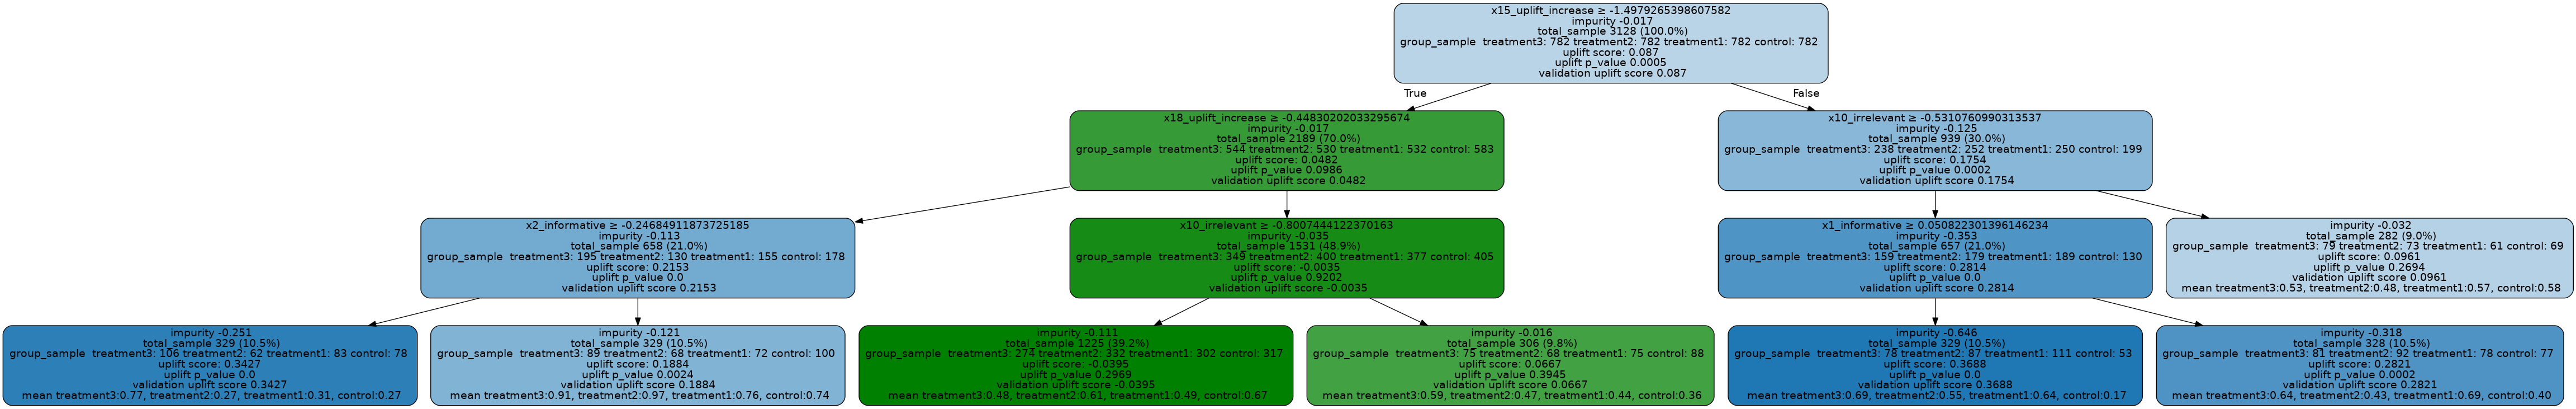

In [33]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

In [34]:
uplift_forest = []
for _ in range(10):
            uplift_tree = UpliftTreeClassifier(
                max_features=10, max_depth=5,
                min_samples_leaf=100,
                min_samples_treatment=10,
                n_reg=10,
                evaluationFunction=None,
                control_name='control',
                normalization=True)

            uplift_forest.append(uplift_tree)

In [35]:
np.random.seed(2020)

In [36]:
treatment_group_keys = list(set(treatment))

In [37]:
treatment_group_keys.remove('control')

In [38]:
treatment_group_keys.sort()

In [39]:
classes_ = {}

In [40]:
for i, treatment_group_key in enumerate(treatment_group_keys):
    classes_[treatment_group_key] = i

In [41]:
classes_

{'treatment1': 0, 'treatment2': 1, 'treatment3': 2}

In [42]:
def bootstrap_pm(X, treatment, y, tree):
        '''
        Serve for bootstrap function. 
        Before feeding to train a tree, we enhance the data by matching on X.
        
        Args
        ----
        X : ndarray, shape = [num_samples, num_features]
            An ndarray of the covariates used to train the uplift model.

        treatment : array-like, shape = [num_samples]
            An array containing the treatment group for each unit.

        y : array-like, shape = [num_samples]
            An array containing the outcome of interest for each unit.
            
        tree: UpliftTreeclassifier Object
        '''
        train_ids = np.arange(0, len(X))
        num_treatments = len(set(treatment))
        t_id = [0] * len(treatment)
        for i in range(len(treatment)):
            if treatment[i] == "treatment1":
                t_id[i] = 1
            elif treatment[i] == "treatment2":
                t_id[i] = 2
            elif treatment[i] == "treatment3":
                t_id[i] = 3
        t_id = np.array(t_id)
        batch = BatchEnhancementOnX()
        batch.make_propensity_lists(train_ids, X, t_id, num_treatments)

        bt_index = np.random.choice(len(X), len(X))
        x_train_bt = X[bt_index]
        y_train_bt = y[bt_index]
        t_train_bt = t_id[bt_index]

        t_indices = list(map(lambda t_idx: np.where(t_train_bt == t_idx)[0], range(num_treatments)))
        t_lens = list(map(lambda x: len(x), t_indices))
        
        base_treatment_idx = np.argmin(t_lens)
        base_indices = t_indices[base_treatment_idx]

        inner_x, inner_t, inner_y = x_train_bt[base_indices], t_train_bt[base_indices], y_train_bt[base_indices]

        x_batch, t_batch, y_batch = batch.enhance_batch_with_propensity_matches(X, treatment, y, inner_x, inner_t, inner_y, num_treatments, 6)
        t_batch_new = [0] * len(t_batch)
        for i in range(len(t_batch)):
            if t_batch[i] == 0:
                t_batch_new[i] = "control"
            elif t_batch[i] == 1:
                t_batch_new[i] = "treatment1"
            elif t_batch[i] == 2:
                t_batch_new[i] = "treatment2"
            else:
                t_batch_new[i] = "treatment3"
        t_batch_new = np.array(t_batch_new)
        t_batch_new.astype(object)
        tree.fit(X=x_batch, treatment=t_batch_new, y=y_batch)
        return tree  

In [102]:
uplift_forest = (bootstrap_pm(X, treatment, y, tree) for tree in uplift_forest)

In [103]:
all_importances = [tree.feature_importances_ for tree in uplift_forest]

KeyError: 'control'

In [43]:
uplift_tree = UpliftTreeClassifier(
                max_features=10, max_depth=5,
                min_samples_leaf=100,
                min_samples_treatment=10,
                n_reg=10,
                evaluationFunction=None,
                control_name='control',
                normalization=True)

In [45]:
tree = bootstrap_pm(X, treatment, y, uplift_tree)

KeyError: 'control'

In [46]:
train_ids = np.arange(0, len(X))
num_treatments = len(set(treatment))
t_id = [0] * len(treatment)
for i in range(len(treatment)):
    if treatment[i] == "treatment1":
        t_id[i] = 1
    elif treatment[i] == "treatment2":
        t_id[i] = 2
    elif treatment[i] == "treatment3":
        t_id[i] = 3

In [48]:
t_id = np.array(t_id)
batch = BatchEnhancementOnX()
batch.make_propensity_lists(train_ids, X, t_id, num_treatments)

In [49]:
bt_index = np.random.choice(len(X), len(X))
x_train_bt = X[bt_index]
y_train_bt = y[bt_index]
t_train_bt = t_id[bt_index]

In [50]:
t_indices = list(map(lambda t_idx: np.where(t_train_bt == t_idx)[0], range(num_treatments)))

In [51]:
t_lens = list(map(lambda x: len(x), t_indices))

In [52]:
base_treatment_idx = np.argmin(t_lens)
base_indices = t_indices[base_treatment_idx]

In [53]:
inner_x, inner_t, inner_y = x_train_bt[base_indices], t_train_bt[base_indices], y_train_bt[base_indices]

In [54]:
x_batch, t_batch, y_batch = batch.enhance_batch_with_propensity_matches(X, treatme, y, inner_x, inner_t, inner_y, num_treatments, 6)

In [55]:
t_batch_new = [0] * len(t_batch)

In [56]:
for i in range(len(t_batch)):
    if t_batch[i] == 0:
        t_batch_new[i] = "control"
    elif t_batch[i] == 1:
        t_batch_new[i] = "treatment1"
    elif t_batch[i] == 2:
        t_batch_new[i] = "treatment2"
    else:
        t_batch_new[i] = "treatment3"

In [57]:
t_batch_new = np.array(t_batch_new)

In [61]:
t_batch_new = t_batch_new.astype(object)

In [62]:
uplift_tree.fit(X=x_batch, treatment=t_batch_new, y=y_batch)

KeyError: 'control'

In [63]:
t_batch_new

array(['treatment2', 'treatment2', 'treatment2', ..., 'treatment3',
       'treatment3', 'treatment3'], dtype=object)

In [67]:
for i in range(len(t_batch)):
    print(t_batch[i])

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1
treatment1

In [65]:
print(t_batch)

[2 2 2 ... 'treatment3' 'treatment3' 'treatment3']


In [68]:
inner_t

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [2]:
import causalml

ModuleNotFoundError: No module named 'causalml'

In [3]:
import scipy

ModuleNotFoundError: No module named 'scipy'

In [4]:
import causalml

ModuleNotFoundError: No module named 'causalml'